## Milestone 1 - Financial Sentiment Analysis

Dan Ellsworth and Alden Pratt

> For our Final Tutorial Project, we will be examining the effectiveness of using sentiment analysis based on Twitter posts relating to publicly traded companies as a leading or lagging indicator of the stock price.  Fluctuations in stock prices can be largely attributed to changes in the attitude of its buyers and holders. As such, platforms in which people are allowed to freely voice their attitude toward a company, such as Twitter, can be influential for a broad audience of traders.  If a particular authority voices optimism regarding the future of a company’s stock, and enough people are convinced into buying, its stock price will increase to meet the increased demand.  Conversely, authority figures voicing pessimism generally results in a lower price.  We will be using company sentiment data from Twitter to see if there is a significant correlation between community sentiment and the change in the stock price. 
> Through studying this issue, several questions arise.  We are curious to know if sentiment generally follows stock prices or if stock prices follow sentiment. In other words, should we be looking at sentiment as a leading or lagging indicator of stock prices?  Who is influential?  Are some companies intrinsically more or less resistant to changes in sentiment?  Can our findings be used in developing a complete and profitable trading strategy?  
    
Below are a couple of data sets containing sentiment analysis for various companies:
    - Sentiment Analysis on Financial Tweets 
    - Stock-Market Sentiment Dataset
    
> To determine the effects that Twitter posts have on stock prices, we plan on combining one of these data sets with historical stock price data that can be pulled from Yahoo Finance.  Yahoo Finance provides data for stock price fluctuations for every company and every day.  We expect that the changes in public sentiment over time will somewhat mirror the changes in the stock price as provided by Yahoo Finance.    



### Setup up and import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime
%matplotlib inline

C:\Users\Danel\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### Extracting Data

In [10]:
# read the data from csv files
StockDF = pd.read_csv('TwitterStockData.csv')
SentimentDF = pd.read_csv('tweet_sentiment.csv')

# declare start and end date for financial data
start = datetime.datetime(2018,7,17)
end = datetime.datetime(2018,10,25)

# read S&P500 data for declared dates
SPY500 = web.DataReader('SPY', 'yahoo', start, end)
BTC = web.DataReader('BTC-USD', 'yahoo', start, end)

StockDF.head()


,text,timestamp,source,symbols,company_names,url,verified
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,TRUE
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,TRUE
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,TRUE
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,TRUE
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,TRUE


In [3]:
SentimentDF.head()

,cleaned_tweets,sentiment
0,video offic mind busi david solomon tell gs in...,0
1,price lumber lb f sinc hit ytd high maci turna...,0
2,say american dream dead,-1
3,barri silbert extrem optimist bitcoin predict ...,1
4,satellit avoid attack space junk circl earth paid,-1


In [4]:
SPY500.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-07-02,272.040009,269.239990,269.510010,271.859985,63554800.0,260.327454
2018-07-03,272.980011,270.420013,272.869995,270.899994,42187100.0,259.408142
2018-07-05,273.179993,270.959991,272.170013,273.109985,56925900.0,261.524384
2018-07-06,275.839996,272.709991,273.140015,275.420013,66493700.0,263.736420
2018-07-09,277.959991,276.500000,276.549988,277.899994,50550400.0,266.111237


In [4]:
# merge the two data frames (tweet info and tweet sentiment) - inner join based on index
StockSentimentDF = StockDF.merge(SentimentDF, how='inner', left_index = True, right_index=True)
StockSentimentDF.head()


,text,timestamp,source,symbols,company_names,url,verified,cleaned_tweets,sentiment
0,VIDEO: “I was in my office. I was minding my o...,Wed Jul 18 21:33:26 +0000 2018,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777...,TRUE,video offic mind busi david solomon tell gs in...,0
1,The price of lumber $LB_F is down 22% since hi...,Wed Jul 18 22:22:47 +0000 2018,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038...,TRUE,price lumber lb f sinc hit ytd high maci turna...,0
2,Who says the American Dream is dead? https://t...,Wed Jul 18 22:32:01 +0000 2018,TheStreet,AIG,American,https://buff.ly/2L3kmc4,TRUE,say american dream dead,-1
3,Barry Silbert is extremely optimistic on bitco...,Wed Jul 18 22:52:52 +0000 2018,MarketWatch,BTC,Bitcoin,https://twitter.com/i/web/status/1019716662587...,TRUE,barri silbert extrem optimist bitcoin predict ...,1
4,How satellites avoid attacks and space junk wh...,Wed Jul 18 23:00:01 +0000 2018,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,TRUE,satellit avoid attack space junk circl earth paid,-1


## Overall Market vs Bitcoin Sentiment
Just for fun!

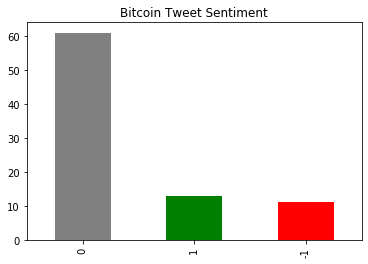

In [13]:
# create a bar graph displaying the number of neutral, positive and negative tweets
colors = ['grey','g','r']
StockSentimentDF[StockSentimentDF.symbols == 'BTC'].sentiment.value_counts().plot.bar(color = colors, title = "Bitcoin Tweet Sentiment")

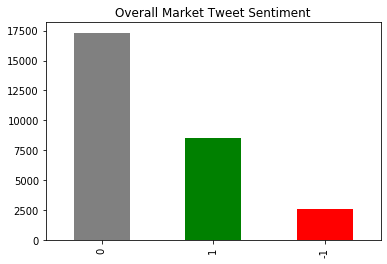

In [14]:

StockSentimentDF.sentiment.value_counts().plot.bar(color = colors, title = "Overall Market Tweet Sentiment")


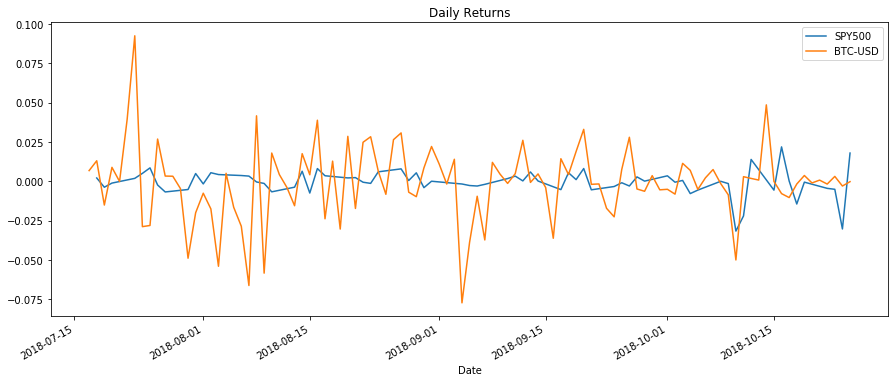

In [11]:
# calculate daily percent change in new column 'returns'
SPY500['returns'] = SPY500['Close'].pct_change(1)
BTC['returns'] = BTC['Close'].pct_change(1)

SPY500['returns'].plot(kind = 'line', title = "Daily Returns", label = 'SPY500', figsize = (15,6))
BTC['returns'].plot(kind = 'line', title = "Daily Returns", label = 'BTC-USD', figsize = (15,6))
plt.legend()
plt.show()

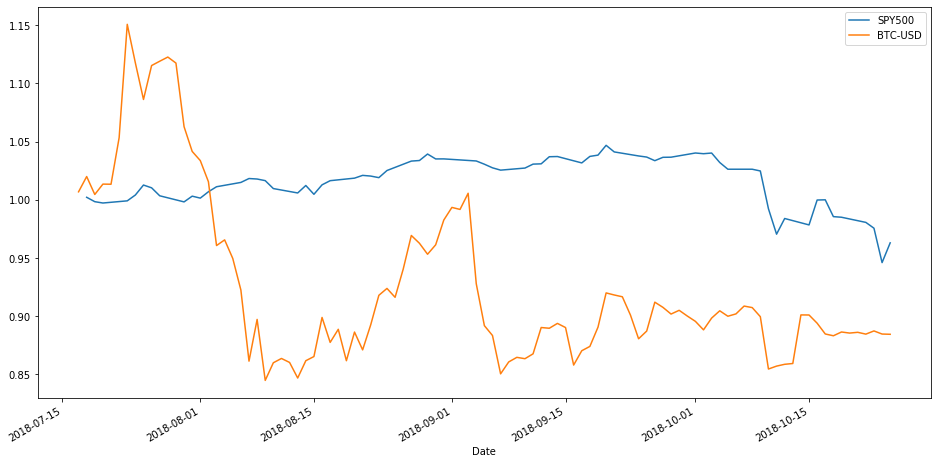

In [12]:
# calculate cumulative returns in a new column ''daily_cumulative_return'
SPY500['daily_cumulative_return'] = ( 1 + SPY500['returns'] ).cumprod()
BTC['daily_cumulative_return'] = ( 1 + BTC['returns'] ).cumprod()

SPY500['daily_cumulative_return'].plot(label='SPY500',figsize= (16,8))
BTC['daily_cumulative_return'].plot(label = 'BTC-USD')
plt.legend();
plt.show()
